### Цели и описание проекта

Целью данного проекта является построение и сравнение моделей машинного обучения для **прогнозирования качества вина** на основе его **физико-химических характеристик**. В качестве исходных данных используется объединённый набор из двух датасетов: **красных и белых вин сорта Vinho Verde**, опубликованных в \[Cortez et al., 2009].

Оценка качества осуществляется по шкале от 0 до 10 и может быть интерпретирована:

* как **регрессионная задача** (предсказание точного значения оценки),
* как **классификационная задача**:

  * в оригинальном виде (много классов: 1–10),
  * в агрегированной форме (3 класса: низкое, среднее, высокое качество).

Проект охватывает следующие направления:

1. Исследовательский анализ данных (EDA)

* Объединение датасетов красных и белых вин.
* Анализ распределений, корреляций между признаками (в т.ч. с использованием Phik-матрицы).
* Обнаружение и обработка выбросов (например, через Z-оценку).
* Масштабирование признаков с помощью StandardScaler, MinMaxScaler и RobustScaler.
* Создание производных признаков.

2. Обучение и оценка моделей

Реализовано несколько подходов:

- Нейросетевые модели

* **Регрессия**: полносвязная нейронная сеть (Feedforward Neural Network) с метриками R² и MAE.
* **Классификация (1–10)**: нейросеть для многоклассовой классификации.
* **Классификация (низкое/среднее/высокое)**: агрегация таргета и обучение отдельной нейросети.

- Классические модели (многоклассовая классификация)

Модели подбирались с использованием RandomizedSearchCV и пайплайнов (`Pipeline` + `ColumnTransformer` + `SelectKBest`):

* **RandomForestClassifier**
* **LogisticRegression**
* **CatBoostClassifier**

Параметры подбирались по:

* выбору скейлера;
* числу лучших признаков (feature selection);
* гиперпараметрам моделей.

3. Оценка качества моделей

Для классификационных задач использовались метрики:

* Accuracy
* F1-мера (взвешенная)
* Матрица ошибок (confusion matrix)

Для регрессионной задачи:

* Коэффициент детерминации (R²)
* Средняя абсолютная ошибка (MAE)

Также визуализировалась зависимость между предсказанными и реальными оценками качества, анализировались сильные и слабые стороны моделей.


### Загрузка и предобработка данных

In [40]:
!pip install phik catboost -q

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import zscore

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    PolynomialFeatures,
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
)

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from phik.report import plot_correlation_matrix
from phik import phik_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# Константы
TEST_SIZE = 0.2
RANDOM_STATE = 42


In [42]:
df_red = pd.read_csv('winequality-red.csv', sep=';')
df_white = pd.read_csv('winequality-white.csv', sep=';')

In [43]:
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [44]:
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [45]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [46]:
df_white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


В данных отсутствуют пропуски, всего 1599 объектов по красному вину и 4898 объектов по белому вину. Все признаки количественные. Принято решение объединить эти два датасета в один предварительно создав категориальный признак тип вина

In [47]:
df_red['type'] = 0
df_white['type'] = 1
df = pd.concat([df_red, df_white], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 710.6 KB


#### Выводы по разделу загрузка и предобработка данных
* Загружены два датасета: **красных** и **белых вин**, содержащие физико-химические параметры и оценки качества.
* Датасеты были успешно **объединены** в единый набор данных для дальнейшего анализа.
* **Пропущенных значений нет**, данные полные и готовы к работе.
* **Преобразование типов не требуется** — все признаки представлены в корректном числовом формате.
* Проведена первичная проверка структуры и статистик данных, признаки готовы для анализа, визуализации и моделирования.


### Исследовательский анализ данных

In [48]:
cat_features = ['type', 'quality']

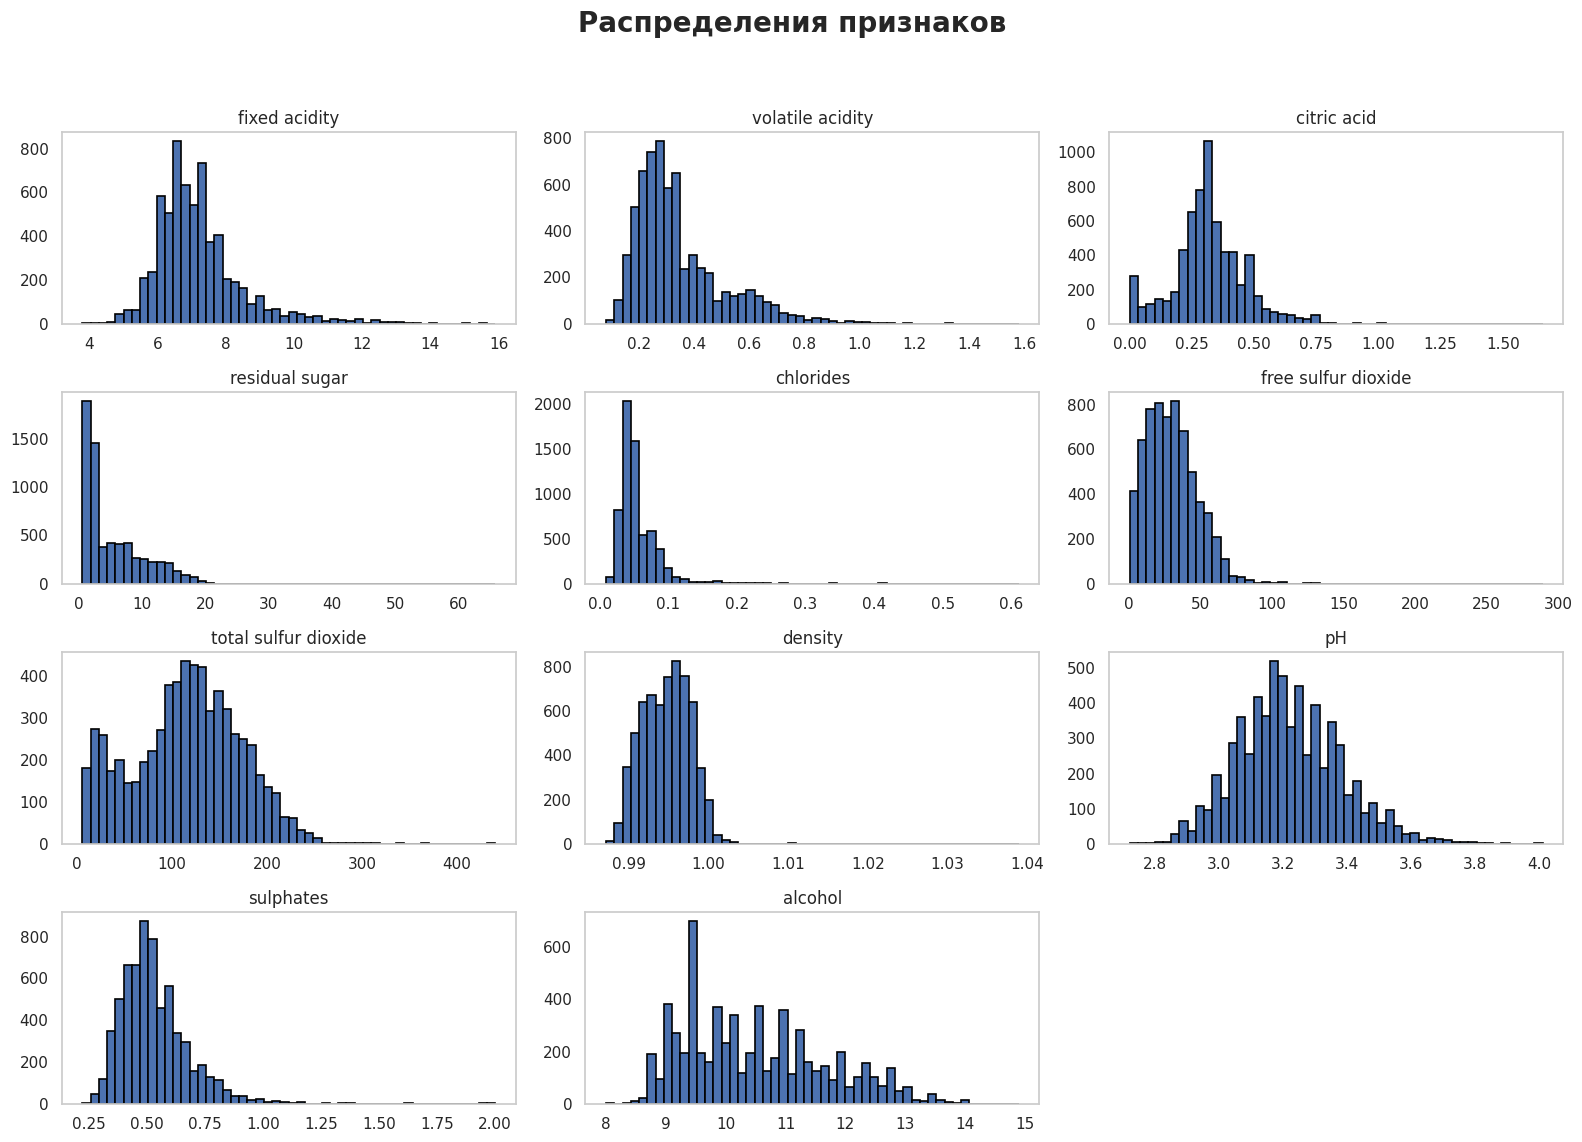

In [49]:
# Посмотрим распределение количественных признаков

sns.set(style="whitegrid")
axes = df.drop(cat_features, axis=1).hist(
    bins=50,
    figsize=(16, 12),
    color="#4C72B0",
    edgecolor="black",
    linewidth=1.2,
    grid=False
)

plt.suptitle("Распределения признаков", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

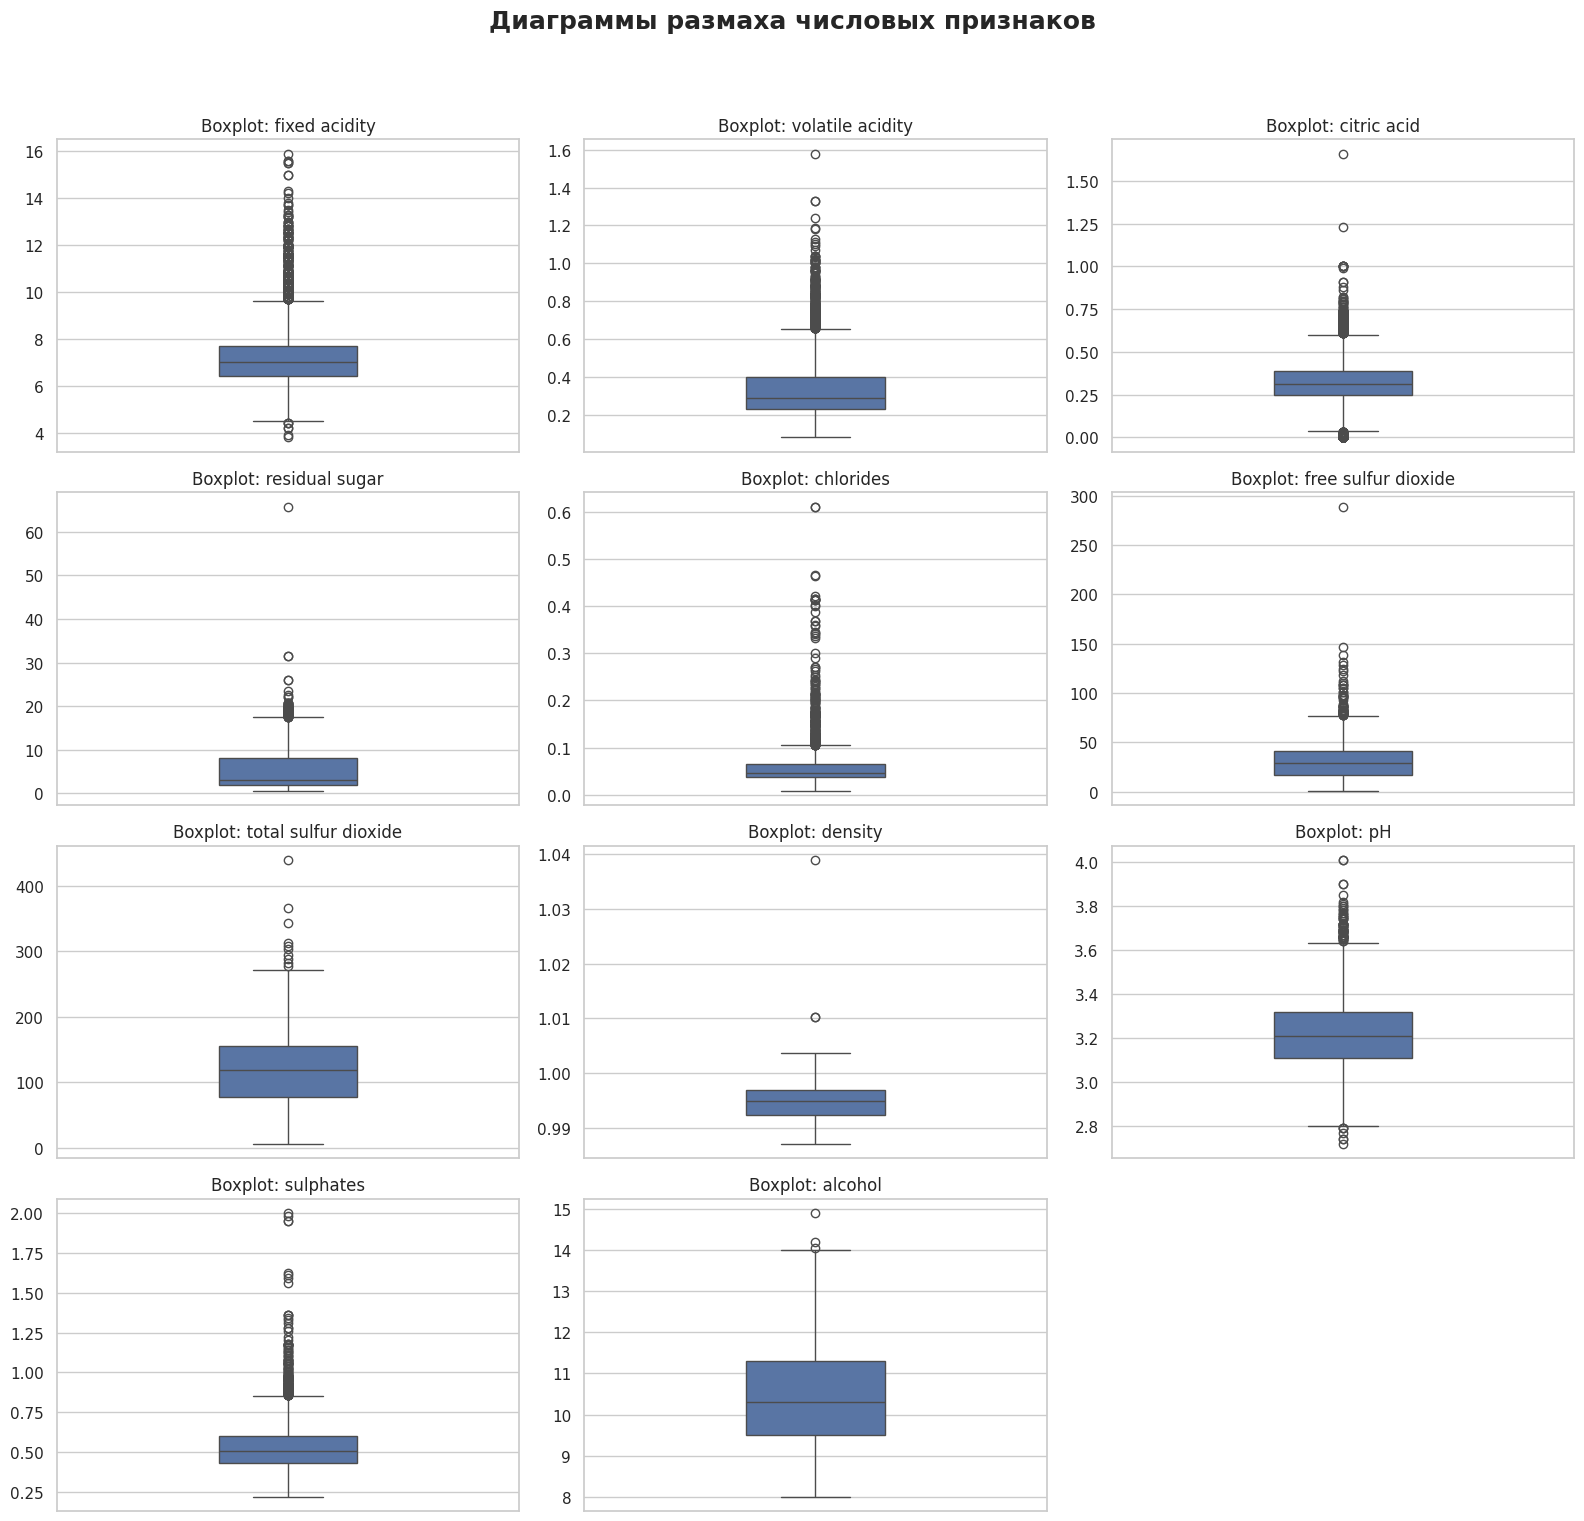

In [50]:
sns.set(style="whitegrid")

num_features = df.drop(columns=cat_features).columns

n_cols = 3
n_rows = (len(num_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(y=df[col], ax=axes[i], color="#4C72B0", width=0.3)
    axes[i].set_title(f'Boxplot: {col}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Удалим лишние пустые оси
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Диаграммы размаха числовых признаков", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Наблюдаются выбросы но в пределах допустимых значений, принял решение оставить как есть.

In [51]:
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

df_filtered = df[filtered_entries]
print(f'Уменьшение размера датасета: {1 - len(df_filtered) / len(df)}')

Уменьшение размера датасета: 0.07818993381560724


Пробовал удалить выбросы (abs(z-score) > 3), но это привело к потере ~7% данных и полному исчезновению редких классов (quality 3 и 9), что нежелательно.
Решено оставить данные без удаления выбросов для сохранения распределения классов. Графикик приведены ниже

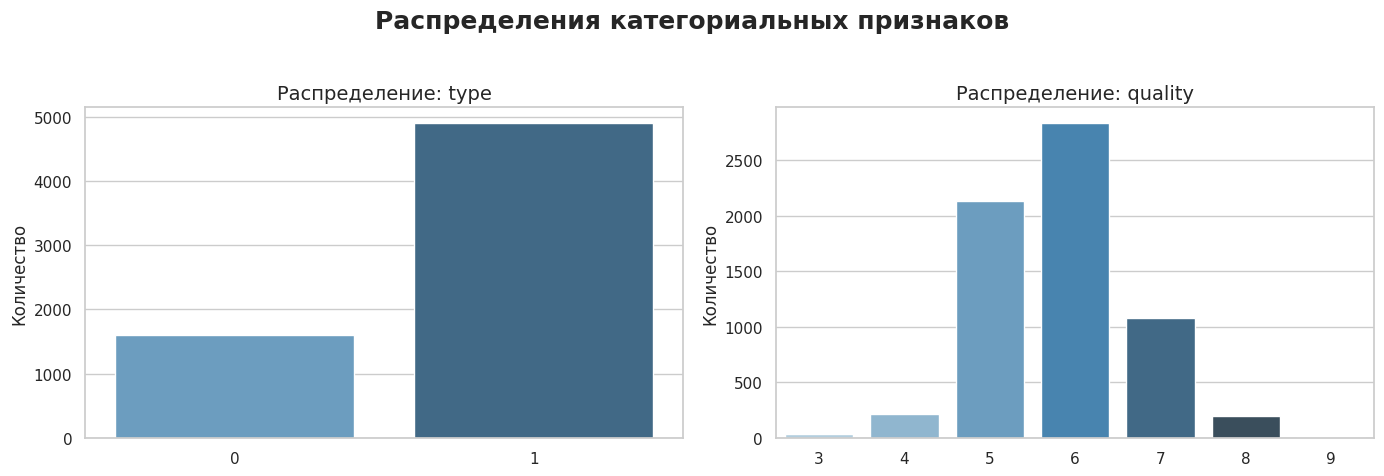

In [52]:
# Посмотрим распределение категориальных признаков
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df, x='type', hue='type', palette='Blues_d', ax=axes[0], legend=False)
axes[0].set_title('Распределение: type', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('Количество')

sns.countplot(data=df, x='quality', hue='quality', palette='Blues_d', ax=axes[1], legend=False)
axes[1].set_title('Распределение: quality', fontsize=14)
axes[1].set_xlabel('')
axes[1].set_ylabel('Количество')

plt.suptitle("Распределения категориальных признаков", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

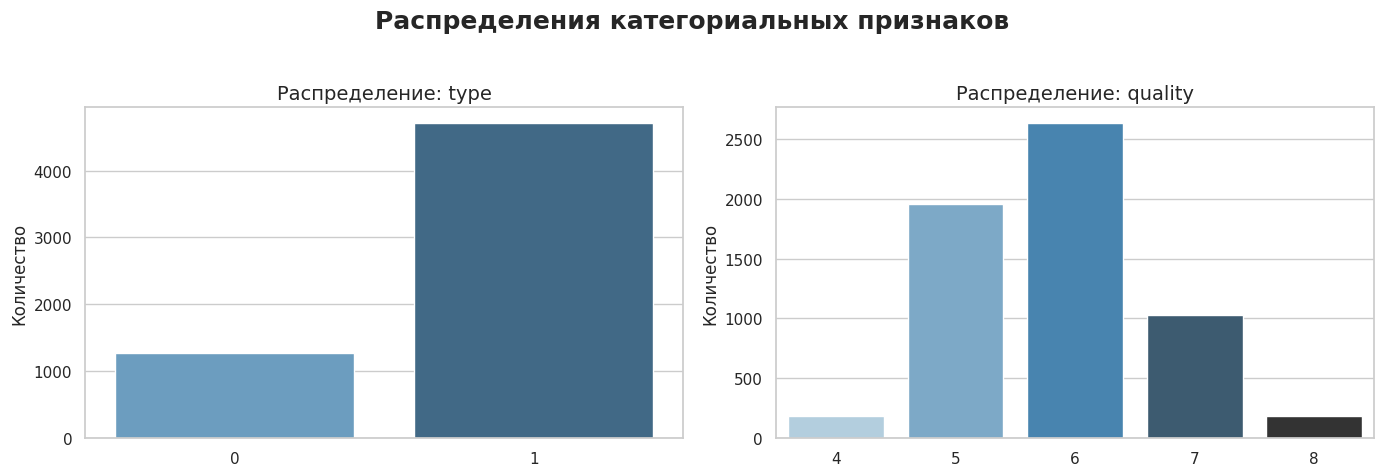

In [53]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df_filtered, x='type', hue='type', palette='Blues_d', ax=axes[0], legend=False)
axes[0].set_title('Распределение: type', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('Количество')

sns.countplot(data=df_filtered, x='quality', hue='quality', palette='Blues_d', ax=axes[1], legend=False)
axes[1].set_title('Распределение: quality', fontsize=14)
axes[1].set_xlabel('')
axes[1].set_ylabel('Количество')

plt.suptitle("Распределения категориальных признаков", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

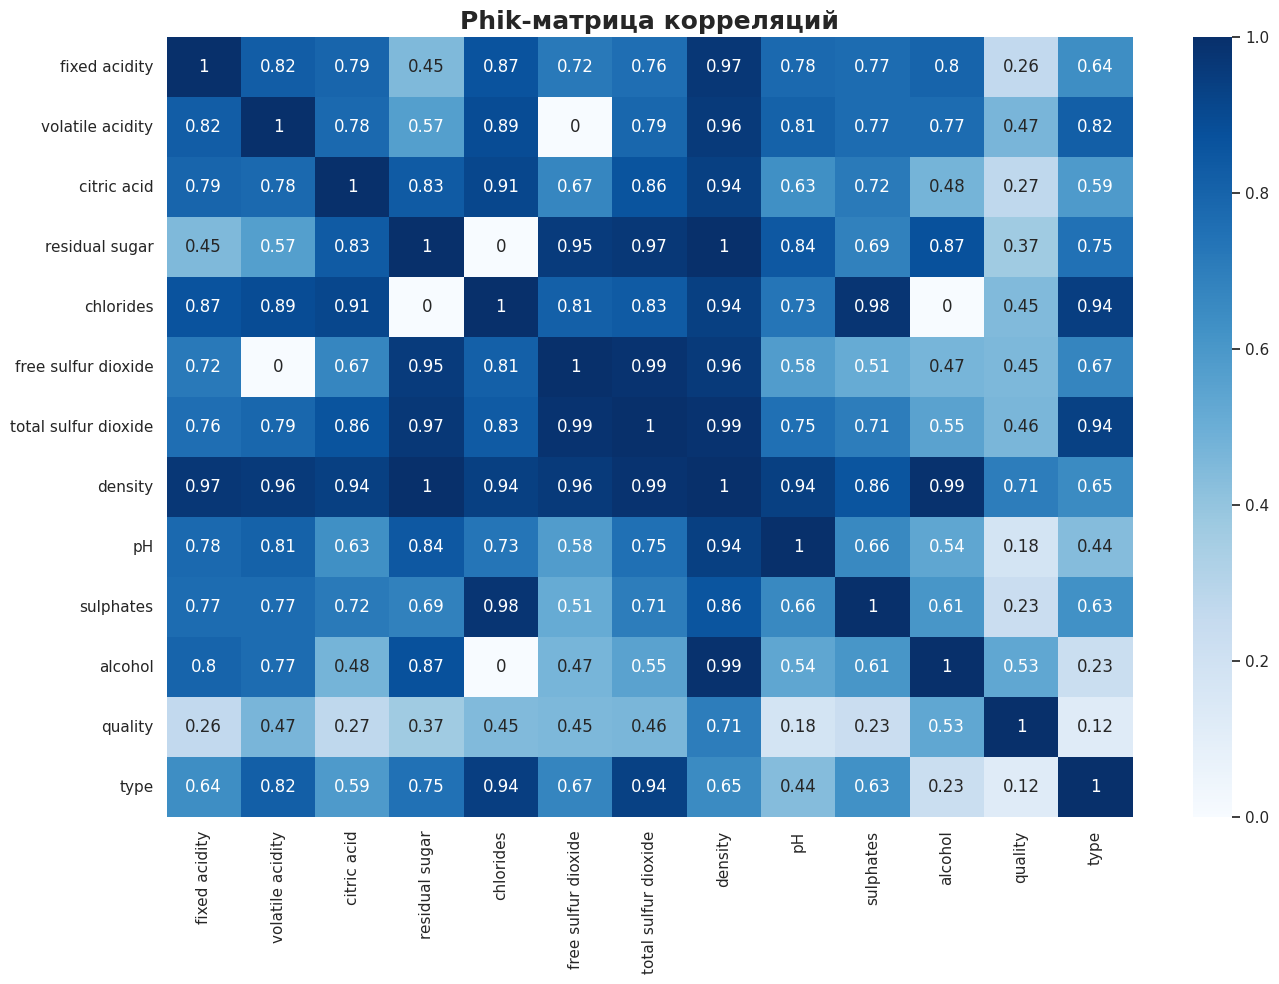

In [54]:
# Посмотрим корреляцию признаков
phik_corr = df.phik_matrix(interval_cols=[])

plt.figure(figsize=(14, 10))
sns.heatmap(phik_corr, annot=True, cmap='Blues', vmin=0, vmax=1)
plt.title("Phik-матрица корреляций", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

Значимые корреляции с качеством:
- Плотность (density): Наибольшая корреляция среди всех признаков. Высокая плотность может указывать на более насыщенный состав вина, что положительно влияет на оценку.

- Алкоголь (alcohol): Второй по силе признак. Более крепкие вина (с высоким содержанием алкоголя) чаще получают лучшие оценки.

- Летучая кислотность (volatile acidity): Умеренная корреляция, но важно учитывать, что слишком высокая летучая кислотность (уксусный оттенок) может ухудшать качество.

- Наблюдается мультиколлениарность признаков плотность и остаточный сахар
- Так как планируется обучать нейросеть, принято решение оставить как есть

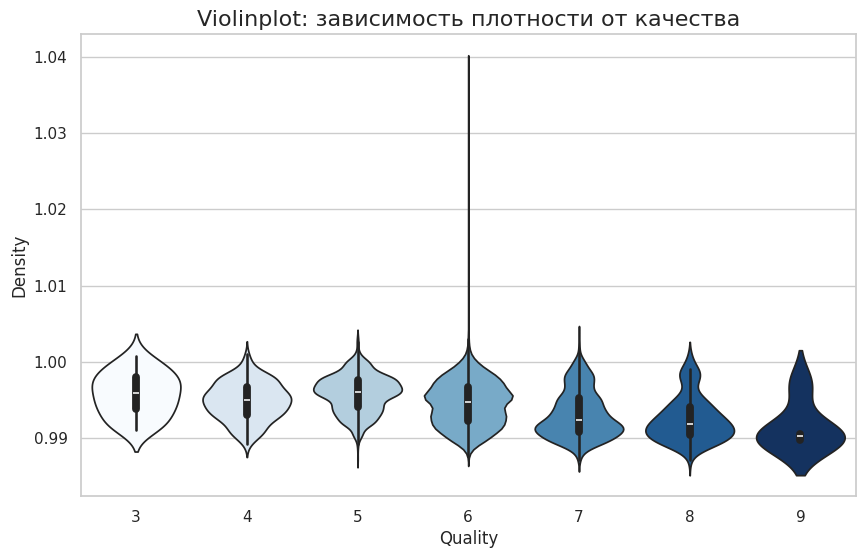

In [185]:
# Рассмотрим завивисмоть плотности Density от качества, так у данного признака наибольшая корреляция с таргетом
plt.figure(figsize=(10, 6))
sns.violinplot(x='quality', y='density',
               hue='quality', legend=False,
               data=df, palette='Blues')
plt.title('Violinplot: зависимость плотности от качества', fontsize=16)
plt.xlabel('Quality')
plt.ylabel('Density')
plt.show()

Большинство значений плотности сконцентрированы в узком диапазоне от ~0.99 до ~1.00 для всех классов качества.
Класс качества 6 имеет наиболее выраженное распределение — это также самый многочисленный класс.
Классы качества 3 и 9 встречаются реже, что видно по сужению "виолончели" — распределение плотности в этих группах уже и менее разнообразно.
В целом, более низкое значение density соответствует более высокому значению качества.

### Cоздание признаков

In [17]:
# создадим новые признаки
df.loc[:, 'alcohol_density_ratio'] = df['alcohol'] / df['density']
df.loc[:, 'total_acidity'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
df.loc[:, 'sulphates_to_chlorides'] = df['sulphates'] / (df['chlorides'] + 1e-6)
df.loc[:, 'acid_sugar_balance'] = df['residual sugar'] / (df['total_acidity'] + 1e-6)
df.loc[:, 'free_to_total_sulfur'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1e-6)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,alcohol_density_ratio,total_acidity,sulphates_to_chlorides,acid_sugar_balance,free_to_total_sulfur
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,9.420726,8.10,7.368324,0.234568,0.323529
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,9.831461,8.68,6.938705,0.299539,0.373134
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,9.829488,8.60,7.065141,0.267442,0.277778
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,9.819639,12.04,7.733230,0.157807,0.283333
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,9.420726,8.10,7.368324,0.234568,0.323529


Созданы новые признаки, которые можно использовать в модели, так же думаю можно попробовать создать полинимальные признаки перед обучением моделей.

### Обучение модели (задача регрессии)

In [18]:
# подготовка данных
X = df.drop(columns=['quality'])
y = df['quality']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

# smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Создаём трансформер до степени 2 (можно увеличить)
poly = PolynomialFeatures(degree=2, include_bias=False)

# Применяем только к числовым данным (у тебя они уже нормализованы)
# X_train_poly = poly.fit_transform(X_train)
# X_val_poly   = poly.transform(X_val)
# X_test_poly  = poly.transform(X_test)


# Масштабируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # обучаем scaler только на train
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [19]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1],  activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mae', metrics=['mae'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 2.1355 - mae: 2.1355 - val_loss: 0.7978 - val_mae: 0.7978
Epoch 2/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0163 - mae: 1.0163 - val_loss: 0.6308 - val_mae: 0.6308
Epoch 3/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8504 - mae: 0.8504 - val_loss: 0.5815 - val_mae: 0.5815
Epoch 4/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7496 - mae: 0.7496 - val_loss: 0.5868 - val_mae: 0.5868
Epoch 5/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7403 - mae: 0.7403 - val_loss: 0.6300 - val_mae: 0.6300
Epoch 6/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7352 - mae: 0.7352 - val_loss: 0.5987 - val_mae: 0.5987
Epoch 7/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6881 - mae: 0.6881 - val_loss: 0.5877 - val_mae: 0.5877
Epoch 8/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6782 - mae: 0.6782 - val_loss: 0.5717 - val_mae: 0.5717
Epoch 9/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

In [20]:
# Результаты модели
y_train_pred = model.predict(X_train).flatten()
y_val_pred   = model.predict(X_val).flatten()
y_test_pred  = model.predict(X_test).flatten()

r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

r2_val = r2_score(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("Метрики модели:")
print(f"Train      — R²: {r2_train:.4f}, MAE: {mae_train:.4f}")
print(f"Validation — R²: {r2_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test       — R²: {r2_test:.4f}, MAE: {mae_test:.4f}")

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Метрики модели:
Train      — R²: 0.2725, MAE: 0.5022
Validation — R²: 0.2294, MAE: 0.5229
Test       — R²: 0.2302, MAE: 0.5297


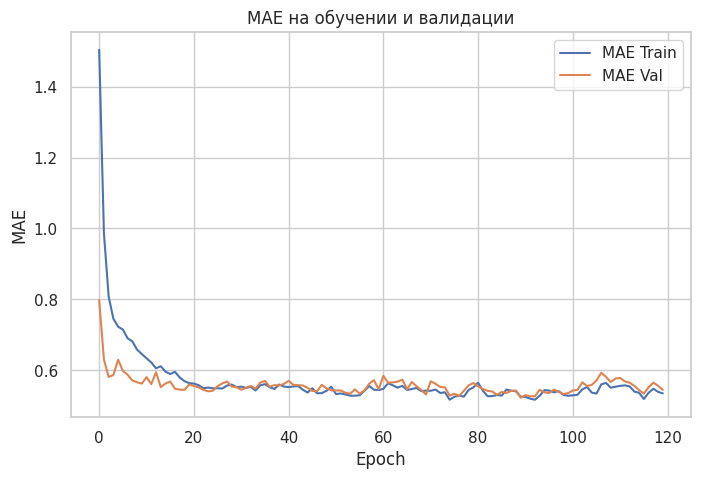

In [21]:
# Динамика метрик при обучении моделей
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='MAE Train')
plt.plot(history.history['val_mae'], label='MAE Val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE на обучении и валидации')
plt.grid(True)
plt.show()

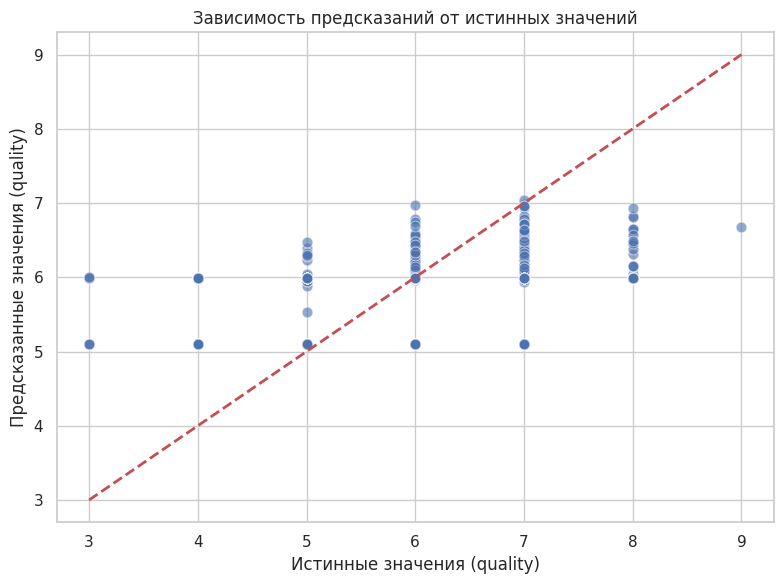

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, color="#4C72B0", alpha=0.6, s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Истинные значения (quality)")
plt.ylabel("Предсказанные значения (quality)")
plt.title("Зависимость предсказаний от истинных значений")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Выводы по разделу
- Была обучена нейронная сеть регрессии (Feedforward Neural Network) для предсказания точного значения качества вина (от 0 до 10) по его физико-химическим свойствам.
- Использовалась архитектура из 4-х слоёв с функцией активации ReLU и регуляризацией Dropout для борьбы с переобучением.
- Модель обучалась с использованием MAE (средняя абсолютная ошибка) в качестве функции потерь, оптимизатор — Adam.
- Данные были разделены на обучающую, валидационную и тестовую выборки в соотношении 60% / 20% / 20%, с учетом стратификации по целевому признаку.
- Модель демонстрирует умеренное качество предсказания, R² ≈ 0.23 на валидационной и тестовой выборках указывает, что модель улавливает часть зависимости, но не способна точно предсказать качество вина.
- Средняя абсолютная ошибка около 0.52–0.53 говорит о среднем отклонении примерно в полбалла, что может быть приемлемо в задачах с субъективными оценками, но видно что модель тяготеет к средним значениям и не улавливает в граничных значениях
- Отсутствие переобучения (train/test метрики близки) говорит о том, что модель стабильна, но недостаточно выразительна — возможно, стоит добавить новые признаки.
- Также возможно, что исходная постановка задачи регрессии — не самая эффективная для предсказания экспертной оценки, так как она изначально дискретна и субъективна.


### Обучение модели (задача классификации)

In [55]:
le = LabelEncoder()
y = le.fit_transform(df['quality'])

X = df.drop(columns=['quality'])
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

# smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=2)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly   = poly.transform(X_val)
X_test_poly  = poly.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_poly)
X_val   = scaler.transform(X_val_poly)
X_test  = scaler.transform(X_test_poly)

In [63]:
n_classes = len(np.unique(y_train))

model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')  # 7 классов исправить
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights_array))



history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
    # class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1901 - loss: 2.3460 - val_accuracy: 0.5166 - val_loss: 1.6857
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3786 - loss: 1.7924 - val_accuracy: 0.5204 - val_loss: 1.5096
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4695 - loss: 1.5454 - val_accuracy: 0.5281 - val_loss: 1.3748
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5016 - loss: 1.4427 - val_accuracy: 0.5319 - val_loss: 1.3069
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5103 - loss: 1.3757 - val_accuracy: 0.5281 - val_loss: 1.2548
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5169 - loss: 1.2819 - val_accuracy: 0.5535 - val_loss: 1.1956
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5385 - loss: 1.2052 - val_accuracy: 0.5627 - val_loss: 1.1547
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5356 - loss: 1.2004 - val_accuracy: 0.5574 - 

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           3      1.000     0.167     0.286         6
           4      0.500     0.070     0.122        43
           5      0.635     0.654     0.644       428
           6      0.601     0.683     0.639       568
           7      0.558     0.532     0.545       216
           8      0.000     0.000     0.000        38
           9      0.000     0.000     0.000         1

    accuracy                          0.605      1300
   macro avg      0.471     0.301     0.320      1300
weighted avg      0.585     0.605     0.587      1300



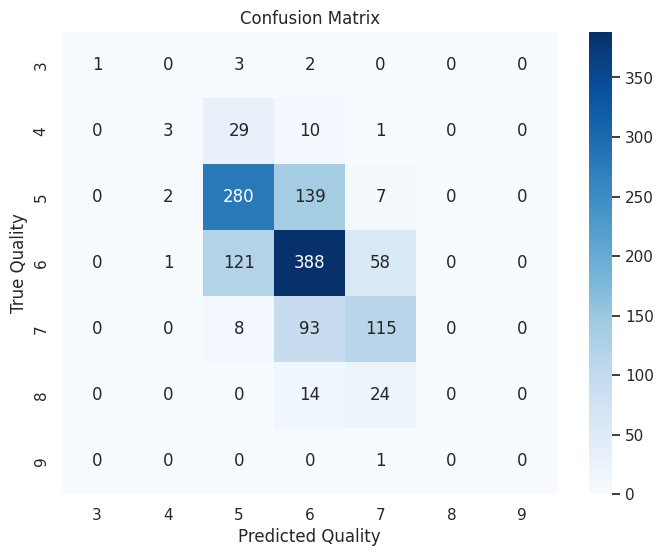

In [65]:
# Предсказания
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)
labels = np.unique(y_test_labels)

print(classification_report(y_test_labels, y_pred_labels, digits=3, zero_division=0))

# Матрица ошибок
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Quality')
plt.ylabel('True Quality')
plt.show()

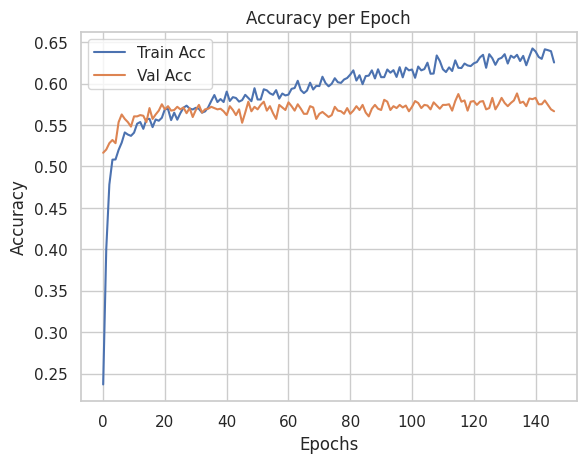

In [66]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

#### Выводы по разделу
Для задачи многоклассовой классификации была построена глубокая нейронная сеть с четырьмя полносвязными слоями и функцией активации softmax на выходе.
В качестве целевой переменной использовались оригинальные значения качества вина (quality ∈ [3, 9]).

Перед обучением был применён полиномиальный признак-инжиниринг степени 2, что позволило модели учитывать взаимодействия между признаками. Также была выполнена нормализация с помощью StandardScaler.

Обучение происходило с использованием стратифицированного разбиения и ранней остановки, чтобы избежать переобучения. Модель обучалась 147 эпох, остановилась на 117-й — моменте минимальной валидационной ошибки.

Модель хорошо различает классы 5 и 6, на которые приходится основная доля выборки (больше 75%).

Классы 3, 4, 8, 9 распознаются плохо или не распознаются вовсе — из-за их крайне малой представленности в выборке.

Класс 8 и 9 не были предсказаны ни разу (recall = 0.0), что подтверждает дисбаланс и необходимость усиленной работы с редкими классами.

### Обучение модели (упрощенный варинат)

In [70]:
# Функция для группировки таргета
def map_quality(value):
    if value <= 4:
        return 0  # низкое
    elif value < 7:
        return 1  # среднее
    else:
        return 2  # высокое

df['quality_group'] = df['quality'].apply(map_quality)
df['quality_group'].value_counts()

,count
quality_group,
1,4974
2,1277
0,246


In [77]:
# Новый таргет
y = df['quality_group'].values

# Удалим старую колонку
X = df.drop(columns=['quality', 'quality_group'])

# Сплит
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

# Полиномиальные признаки
# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_train = poly.fit_transform(X_train)
# X_val   = poly.transform(X_val)
# X_test  = poly.transform(X_test)

# Масштабирование
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# Оверсемплинг
# smote = SMOTE(random_state=RANDOM_STATE)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [78]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # теперь 3 класса
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7307 - loss: 0.6968 - val_accuracy: 0.7744 - val_loss: 0.5763
Epoch 2/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7787 - loss: 0.5594 - val_accuracy: 0.7852 - val_loss: 0.5570
Epoch 3/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7923 - loss: 0.5303 - val_accuracy: 0.7814 - val_loss: 0.5403
Epoch 4/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7920 - loss: 0.5233 - val_accuracy: 0.7837 - val_loss: 0.5423
Epoch 5/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7856 - loss: 0.5310 - val_accuracy: 0.7783 - val_loss: 0.5258
Epoch 6/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7850 - loss: 0.5285 - val_accuracy: 0.7875 - val_loss: 0.5336
Epoch 7/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7847 - loss: 0.5204 - val_accuracy: 0.7868 - val_loss: 0.5174
Epoch 8/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7963 - loss: 0.4888 - val_accu

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

         low       0.43      0.06      0.11        49
      medium       0.82      0.93      0.88       995
        high       0.62      0.40      0.49       256

    accuracy                           0.80      1300
   macro avg       0.62      0.47      0.49      1300
weighted avg       0.77      0.80      0.77      1300



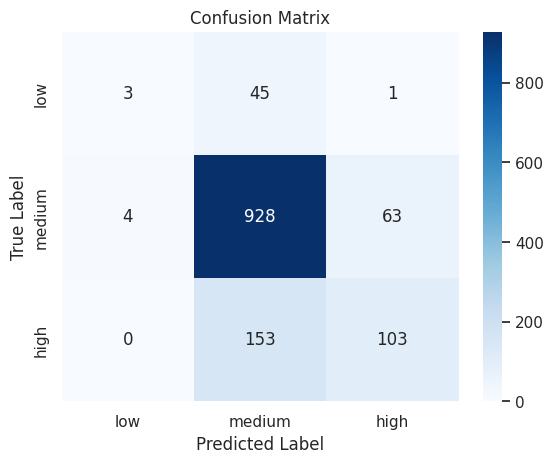

In [79]:
# Предсказания
y_pred = model.predict(X_test).argmax(axis=1)

labels = ['low', 'medium', 'high']

print(classification_report(y_test, y_pred, target_names=labels))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Вывод по разделу
Модель нейронной сети с двумя скрытыми слоями (128 и 64 нейрона) и функцией активации ReLU успешно обучилась на задаче многоклассовой классификации сгруппированного качества вина.

- Качество модели на валидации:

Лучшая достигнутая val_accuracy ≈ 80.2%, при val_loss ≈ 0.47 (на 56-й эпохе).

Эффективно сработала ранняя остановка (early stopping), предотвращающая переобучение.

- Результаты на тестовой выборке:

Точность (accuracy): 80%

F1-мера (macro avg): 0.51, что указывает на несбалансированность классов.

Класс "medium" (основной по частоте) классифицируется лучше всего:

precision = 0.82, recall = 0.93, f1 = 0.88

Классы "low" и "high" предсказываются значительно хуже:

"low": f1 = 0.17 (из-за малого количества примеров)

"high": f1 = 0.47

- Причины снижения качества по классам "low" и "high":

Сильный дисбаланс классов: "medium" — 4974 примеров, "low" — всего 246

### Обучение модели (классические модели)

In [151]:
y = df['quality'].values

# Удалим старую колонку
X = df.drop(columns=['quality', 'quality_group'])

# делим данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y)

# Полиномиальные признаки
poly = PolynomialFeatures(degree=2, include_bias=False)



X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.transform(X_test)

poly_feature_names = poly.get_feature_names_out(X.columns)

X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train.index)
X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_feature_names, index=X_test.index)

num_features = X_test_poly_df.columns

# num_features = X_train.drop('type', axis=1).columns
# num_features = X_train.columns

# cat_features = ['type']

In [155]:
select_range = range(15, len(num_features) + 1, 5)




preprocessor = ColumnTransformer(
                    transformers=[
                            ('num', Pipeline([
                                    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                                    ('scaler', 'passthrough')]), num_features),

                            # ('cat', Pipeline([
                            #         ('imputer', SimpleImputer(strategy='most_frequent')),
                            #         ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]), cat_features)
                    ],
                    remainder='drop'
                        )

num_pipe_ss = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

num_pipe_mm = make_pipeline(
    SimpleImputer(strategy='mean'),
    MinMaxScaler()
)

num_pipe_rob = make_pipeline(
    SimpleImputer(strategy='mean'),
    RobustScaler()
)

# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
                    ('preprocessor', preprocessor),
                    ('select', SelectKBest(score_func=f_classif, k=20)),
                    ('classifier', 'passthrough')])

In [162]:
param_grid = [
    # параметры для RandomForest
    {
        'preprocessor__num__scaler': [num_pipe_ss, num_pipe_mm, num_pipe_rob],
        'classifier': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'select__k': select_range,
    },

    # параметры для LogisticRegression
    {
        'preprocessor__num__scaler': [num_pipe_ss, num_pipe_mm, num_pipe_rob],
        'classifier': [LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)],
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2'],  # Упрощено: только L2
        'classifier__solver': ['lbfgs','liblinear', 'sag', 'saga'],
        'select__k': select_range,
    },

    # параметры для CatBoost
    {
        'preprocessor__num__scaler': [num_pipe_ss, num_pipe_mm, num_pipe_rob],
        'classifier': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)],
        'classifier__iterations': [100, 500, 1000],
        'classifier__learning_rate': [0.05, 0.1],

        'select__k': select_range,
    },

    # # параметры для SVM
    # {
    #     'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
    #     'classifier': [SVC(probability=True, random_state=RANDOM_STATE)],
    #     'classifier__C': [0.1, 1, 10],
    #     'classifier__kernel': ['linear', 'rbf'],
    #     'classifier__gamma': ['scale', 'auto']
    # }
]

In [163]:
%%time
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    n_iter=30,
    cv=cv_strategy,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE
    )


random_search.fit(X_train_poly_df, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


CPU times: user 6.61 s, sys: 480 ms, total: 7.09 s
Wall time: 5min 31s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                'passthrough')]),
                                                                               Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxid...
                                         'preprocessor__num__scaler': [Pipeline(steps=[('simpleimputer',
                                                                                        SimpleImputer()),
                                                                                       ('standardscaler',
                                                                                        StandardScaler())]),
                                                                       Pipeline(steps=[('simpleimputer',
                                                                                        SimpleImputer()),
                                                                                       ('minmaxscaler',
                                                                                        MinMaxScaler())]),
                                                                       Pipeline(steps=[('simpleimputer',
                                                                                        SimpleImputer()),
                                                                                       ('robustscaler',
                                                                                        RobustScaler())])],
                                         'select__k': range(15, 91, 5)}],
                   random_state=42, scoring='f1_weighted', verbose=2)

In [169]:
print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучшая оценка (F1): {random_search.best_score_:.4f}")

Лучшие параметры: {'select__k': 55, 'preprocessor__num__scaler': Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('robustscaler', RobustScaler())]), 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__max_depth': 20, 'classifier': RandomForestClassifier(random_state=42)}
Лучшая оценка (F1): 0.6536


In [168]:
y_pred = random_search.predict(X_test_poly_df)
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
print(f'Метрика F1 на тестовой выборке: {round(f1, 4)}')
print(f'Метрика accuracy на тестовой выборке: {round(accuracy, 4)}')

Метрика F1 на тестовой выборке: 0.6853
Метрика accuracy на тестовой выборке: 0.6954


              precision    recall  f1-score   support

           3      0.000     0.000     0.000         6
           4      0.583     0.163     0.255        43
           5      0.734     0.748     0.741       428
           6      0.676     0.765     0.718       567
           7      0.665     0.597     0.629       216
           8      0.875     0.359     0.509        39
           9      0.000     0.000     0.000         1

    accuracy                          0.695      1300
   macro avg      0.505     0.376     0.407      1300
weighted avg      0.693     0.695     0.685      1300



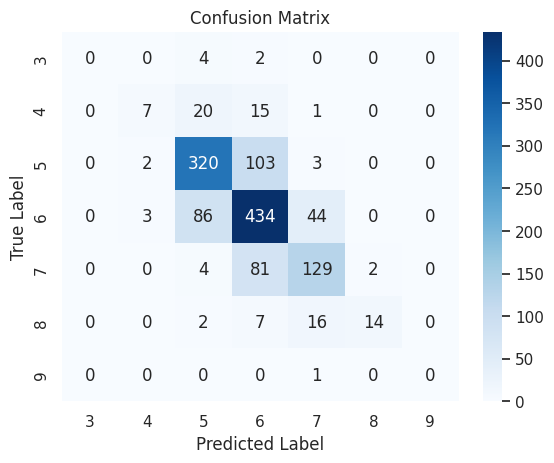

In [177]:
print(classification_report(y_test, y_pred, digits=3, zero_division=0))

labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

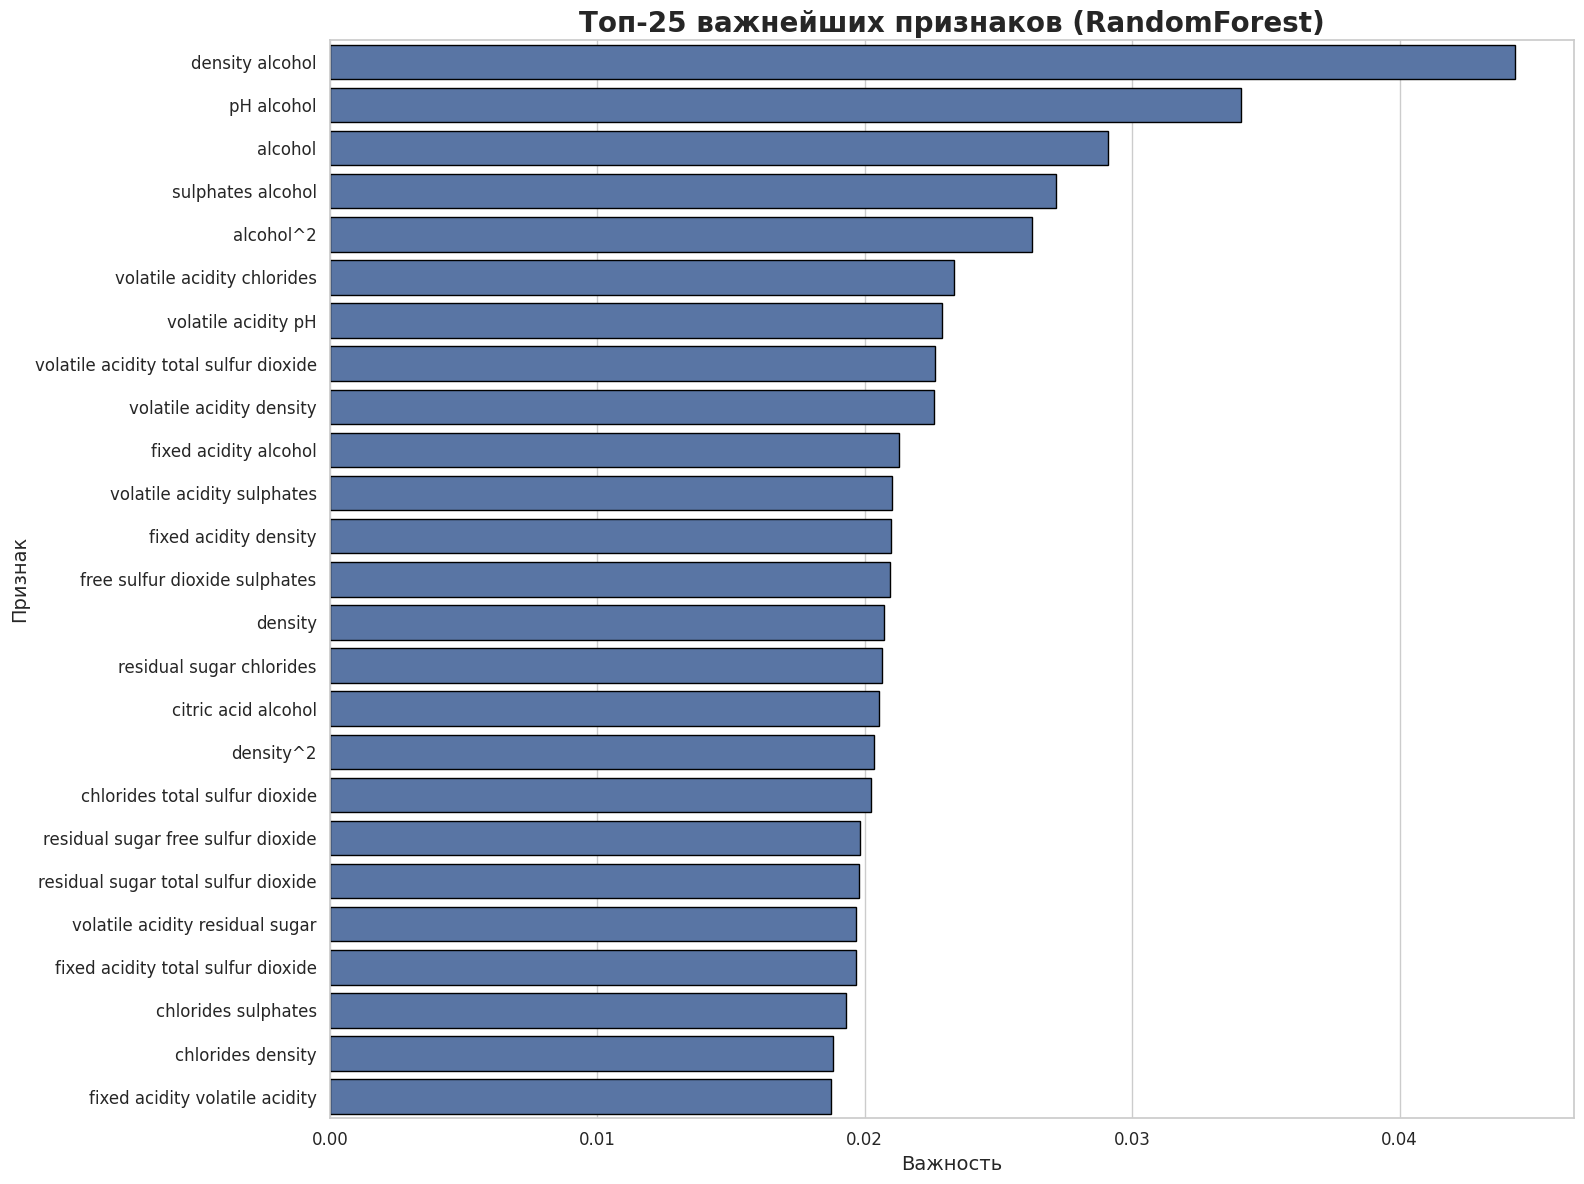

In [183]:
# Получим маску отобранных признаков
select_mask = random_search.best_estimator_.named_steps['select'].get_support()

X_transformed = random_search.best_estimator_.named_steps['preprocessor'].transform(X_train_poly_df)
selected_features = X_train_poly_df.columns[select_mask]

best_model = random_search.best_estimator_.named_steps['classifier']

importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)


sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(25),
    color="#4C72B0",
    edgecolor="black"
)

plt.title("Топ-25 важнейших признаков (RandomForest)", fontsize=20, fontweight='bold')
plt.xlabel("Важность", fontsize=14)
plt.ylabel("Признак", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

#### Вывод по разделу
- Использованы полиномиальные признаки 2-й степени, что позволило учесть нелинейные взаимосвязи.

- Вектор признаков масштабировался с помощью трёх стратегий: StandardScaler, MinMaxScaler, RobustScaler.

- Для отбора признаков применялся SelectKBest с f_classif.

- Подбор гиперпараметров осуществлялся через RandomizedSearchCV по 30 комбинациям и с StratifiedKFold (учёт дисбаланса классов).

- Оценка качества проводилась по метрике F1 (взвешенное среднее).

- RandomForest показал наилучший баланс между точностью и обобщающей способностью, уверенно справляясь с основными классами.

- Дисбаланс классов остаётся проблемой — редкие классы (3, 9) модель практически игнорирует.

- Полиномиальные признаки и отбор фичей улучшили результаты, особенно для средних классов.

- Категориальные признаки (например, type) не использовались — их подключение может дополнительно улучшить модель.

- CatBoost и LogisticRegression не превзошли RandomForest, вероятно, из-за сильной зависимости от качества признаков и чувствительности к масштабированию.

- Наиболее важным признаком для модели является комбинация плотности и алкоголя (density alcohol), что говорит о сильной взаимосвязи этих характеристик с целевой переменной.

- Алкоголь в различных видах (прямой, в степени, в сочетании с другими признаками) стабильно входит в топ признаков по важности, подчеркивая его ключевое влияние.

- Несколько взаимодействий с кислотностью (volatile acidity) и другими химическими параметрами (chlorides, pH, sulphates) также существенно влияют на модель, что отражает комплексное влияние химического состава вина.

### Общие выводы по проекту

Проект продемонстрировал всесторонний подход к задаче прогнозирования качества вина:

- Регрессионная нейросеть показала ограниченную способность точно предсказывать оценки (R² ≈ 0.23), но стабильную работу без переобучения.

- Многоклассовая классификация на оригинальных метках показала, что даже глубокая нейросеть не справляется с дисбалансом — слабое распознавание редких классов.

- Сгруппированная классификация (low/medium/high) позволила достичь наилучших результатов (accuracy ≈ 80%), особенно для основного класса (medium).

- Классические модели, особенно RandomForest, показали надёжную и интерпретируемую альтернативу — лучшие F1-метрики при простом и устойчивом обучении.

- Использование полиномиальных признаков, SelectKBest, скейлеров и StratifiedKFold повысило эффективность моделей.

Что можно улучшить (кратко)
- Обработка дисбаланса - Применить SMOTE, class weights или oversampling (к сожалению их применение пока ухудшает метрику на трейне)

- Постановка задачи - основной потенциал — в сгруппированной классификации. Регрессия в текущей постановке не даёт конкурентных результатов.

